# Scalar field theory

In [ ]:
import flax
import flax.nnx as nnx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax_autovmap import autovmap

import bijx

## Free theory

In [ ]:
mass = 0.5
lat_shape = (32, 32)

# constructing scaling explicitly here;
# note there is also bijx.FreeTheoryScaling (see MCMC section below)
ks = bijx.fourier.fft_momenta(lat_shape, lattice=True)
spectrum = 1 / (mass**2 + jnp.sum(ks**2, axis=-1))

# note: spectrum here could also be a nnx.Param to make it trainable;
# or set it to output of (trainable) function of ks
scaling = bijx.SpectrumScaling(spectrum)

free_theory_prior = bijx.Transformed(
    bijx.IndependentNormal(lat_shape, rngs=nnx.Rngs(sample=0)),
    scaling
)

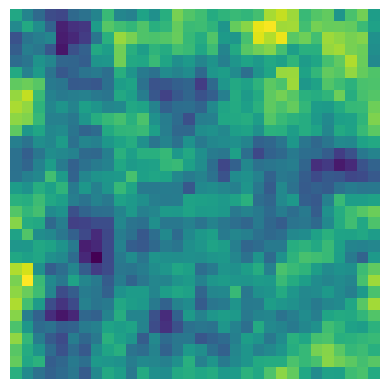

In [ ]:
x, _ = free_theory_prior.sample()
plt.imshow(x)
plt.axis('off')
plt.show()

## Scalar $\phi^4$ theory

In this section the use of the {class}`ConvCNF` network is demonstrated, as well as other methods for the scalar theory.
The architecture was originally introduced in [[2207.00283]](https://arxiv.org/abs/2207.00283) with code available on [github](https://github.com/mathisgerdes/continuous-flow-lft/tree/master) using the haiku jax library.
In particular, below is a demonstration of how [previously published](https://zenodo.org/records/7547918) trained parameters can be converted and used in this framework.

In [ ]:
# "build" provides a constructor similar to the jaxnf version

rngs = nnx.Rngs(params=0)
vf = bijx.ConvVF.build((32, 32), (), rngs=rngs)

### Transfer model parameters from previous version

In [ ]:
# convolution conventions change between frameworks, need to relabel orbits

def reshuffle_orbits(kernel_params, kernel_shape):
    oc, old_orbits = bijx.nn.conv.kernel_d4(kernel_shape)
    old_orbits = old_orbits[::-1, ::-1]
    kernel = bijx.nn.conv.unfold_kernel(kernel_params, old_orbits)
    for d, s in enumerate(kernel.shape[:-2]):
        kernel = jnp.roll(kernel, -1 + (s % 2), axis=d)
    return bijx.nn.conv.fold_kernel(kernel, vf.conv.orbits, oc)

In [ ]:
# transfer haiku -> this
file_path = '../../../data/single-L32.npz'  # set this to where parameters are stored
try:
    params_haiku = np.load(file_path, allow_pickle=True)['params'].item()

    _, params = nnx.split(vf)

    params.replace_by_pure_dict({
        'conv': {'kernel_params': reshuffle_orbits(params_haiku['~']['w'], (32, 32))},
        'feature_map': {'features': {0: {'phi_freq': params_haiku['~']['phi_freq'][None]}}},
        'feature_superposition': params_haiku['~']['freq_superpos'],
        'time_kernel': {'superposition': params_haiku['~']['time_superpos']}
    })

    # in place update
    nnx.update(vf, params)
except FileNotFoundError:
    print('skipping parameter loading')

### Sampling

In [ ]:
flow = bijx.ContFlowDiffrax(vf, config=bijx.DiffraxConfig(dt=1/10))
sampler = bijx.Transformed(
    bijx.IndependentNormal((32, 32), rngs=nnx.Rngs(sample=0)),
    flow,
)

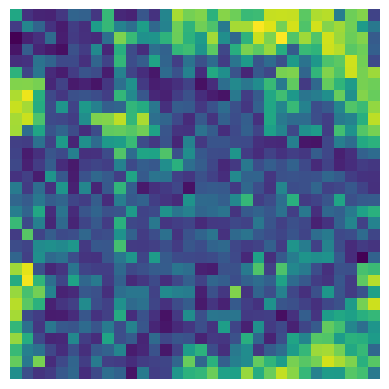

In [ ]:
x, _ = sampler.sample(())
plt.imshow(x)
plt.axis('off')
plt.show()

### MCMC sampling

As an example of how independent Metropolis-Hastings can be used to generate samples via a Markov chain, we will consider a simple free theory in the following.
In particular, we will measure the acceptance rate of the Markov chian when we use a free theory of fixed mass as proposal, and increase the non-gaussian $\phi^4$ coupling $\lambda$ in the target theory.

In [ ]:
rngs = nnx.Rngs(43)

In [ ]:
mass = 0.5
lat_shape = (32, 32)

sampler = bijx.Transformed(
    bijx.IndependentNormal(lat_shape, rngs=nnx.Rngs(sample=0)),
    bijx.FreeTheoryScaling(mass**2, lat_shape, half=False)
)

In [ ]:
# for convenience, define our phi4 theory
from dataclasses import dataclass

@dataclass
class Phi4Theory(nnx.Pytree):
    m2: float = -4
    lam: float = 5.0

    @autovmap(None, 2)
    def action(self, phi):
        act = bijx.lattice.scalar.phi4_term(phi, self.m2, self.lam)
        return jnp.sum(act) # / 2

    def log_prob(self, phi):
        return -self.action(phi)

In [ ]:
@jax.jit
def imh_step(rng, state, mass, lam):
    target = Phi4Theory(m2=mass**2, lam=lam)
    imh = bijx.mcmc.IMH(sampler, target.log_prob)
    return imh.step(rng, state)

@jax.jit
def imh_init(rng, mass, lam):
    target = Phi4Theory(m2=mass**2, lam=lam)
    imh = bijx.mcmc.IMH(sampler, target.log_prob)
    return imh.init(rng)

In [ ]:
lams = np.linspace(0, 0.5, 8)
accept_rate = np.zeros(len(lams))

for i, lam in enumerate(lams):
    count = 5000
    accepted = 0

    state = imh_init(rngs(), mass, lam)

    for _ in range(count):
        state, info = imh_step(rngs(), state, mass, lam)
        accepted += info.is_accepted
    accept_rate[i] = accepted / count

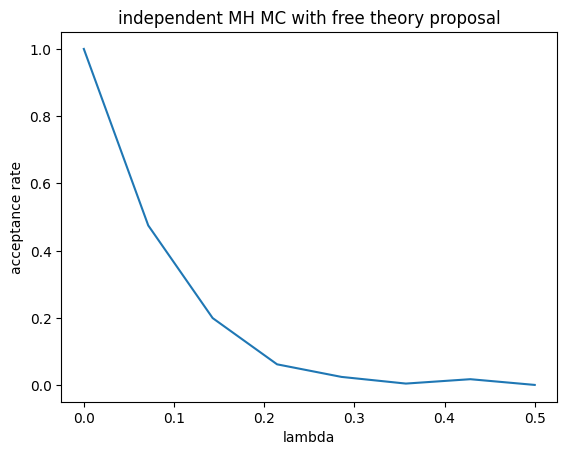

In [ ]:
plt.title('independent MH MC with free theory proposal')
plt.plot(lams, accept_rate)
plt.xlabel('lambda')
plt.ylabel('acceptance rate')
plt.show()